In [2]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [3]:
directory_path = r'C:/Users/borge/Desktop/HPLC_3D'
os.chdir(directory_path)
%pwd

'C:\\Users\\borge\\Desktop\\HPLC_3D'

### Converte os arquivos exportados para arquivos de tabela simples

In [25]:
import pandas as pd

# Specify the file path
file_name = "Polyporus.txt"

# Read the text file
with open(file_name, 'r') as file:
    # Find the line where the matrix starts (assuming it starts with "R.Time (min)")
    start_line = None
    for i, line in enumerate(file):
        if line.startswith("R.Time (min)"):
            start_line = i + 1
            break

    # Check if "R.Time (min)" was found
    if start_line is None:
        raise ValueError("Matrix starting line not found in the file.")

    # Move the file pointer to the starting line
    file.seek(0)
    for _ in range(start_line):
        next(file)

    # Read the matrix into a Pandas DataFrame, skipping the last 4 rows
    df = pd.read_csv(file, delim_whitespace=True, index_col=False, skipfooter=4, engine='python', header=None)

# Set the first row as column headers and "RT(min)" as the header for the first column
df.columns = df.iloc[0]
df = df.iloc[1:]

# Rename the first column to "RT(min)"
df.rename(columns={df.columns[0]: "RT(min)"}, inplace=True)


# Display the DataFrame
df.to_csv(f"{file_name[:-4]}_conv.csv", sep=";")

C:\Users\borge\AppData\Local\Temp\ipykernel_37280\1904270496.py:25: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(file, delim_whitespace=True, index_col=False, skipfooter=4, engine='python', header=None)


#### Análise dos dados

In [41]:
print(df.shape)
df.head(2)

df2 = df.drop("RT(min)", axis=1)
axis = df[["RT(min)"]]


(3751, 490)


<Figure size 1000x600 with 0 Axes>

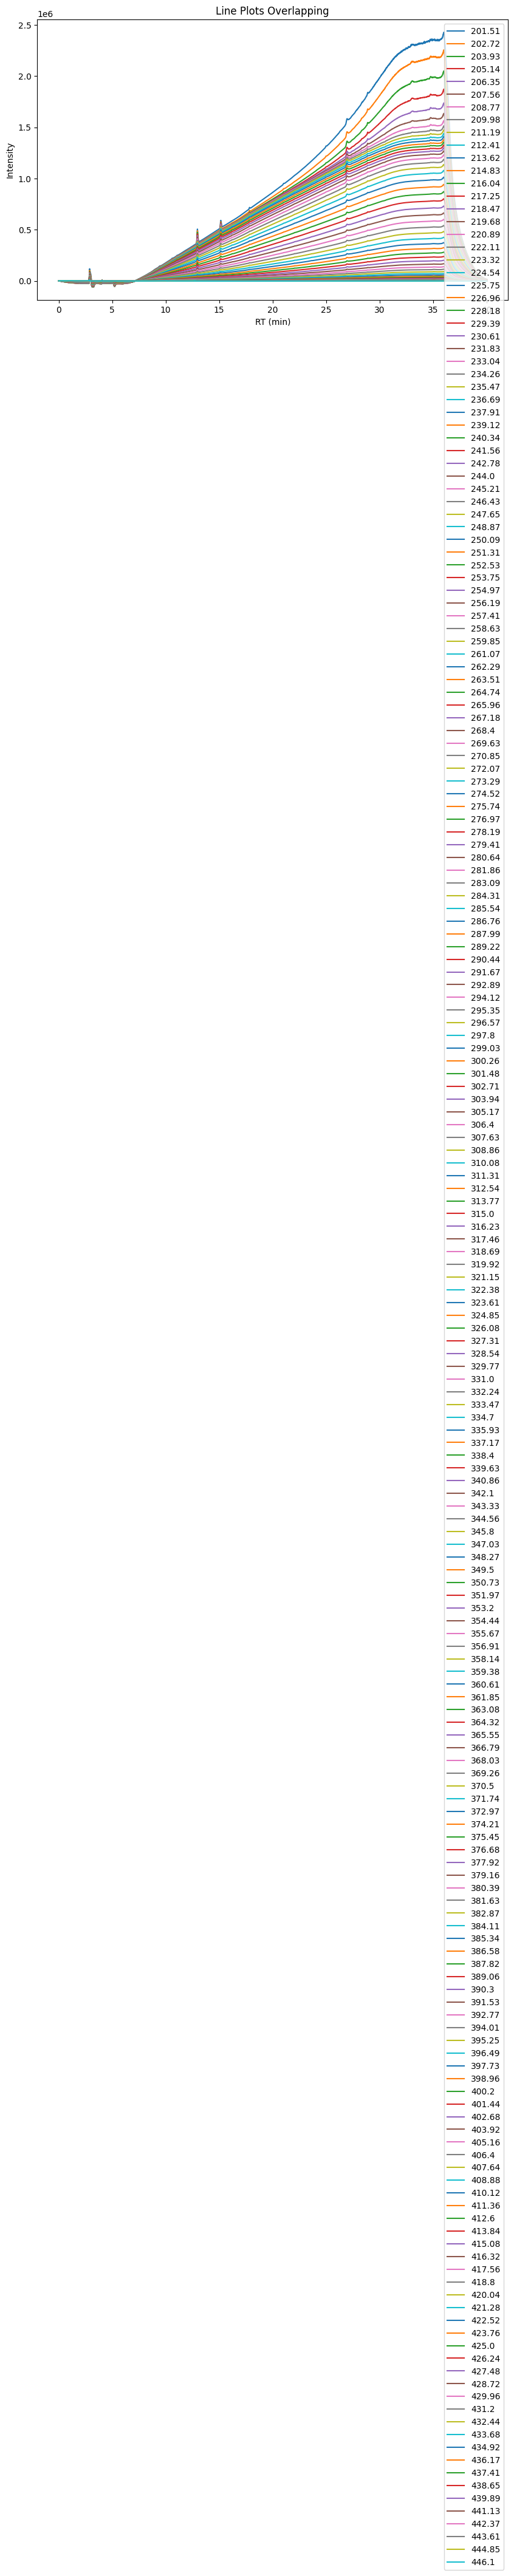

In [44]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the range of columns you want to plot (columns 4 to 8 in this case)
start_column = 1 # always to be higher then 1 (the RT axis)
end_column = 200

# Enable interactive mode in Jupyter Notebook
%matplotlib inline

# Plotting
plt.figure(figsize=(10, 6))

# Loop through the specified range of columns and plot a line
for column in df2.columns[start_column:end_column + 1]:
    plt.plot(axis, df2[column], label=column)

# Add labels and title
plt.xlabel('RT (min)')
plt.ylabel('Intensity')
plt.title('Line Plots Overlapping')

# Add a legend
plt.legend()

# Set the axis limits to enable zooming
#plt.axis([xmin, xmax, ymin, ymax])

# Show the plot
plt.show()


### PCA

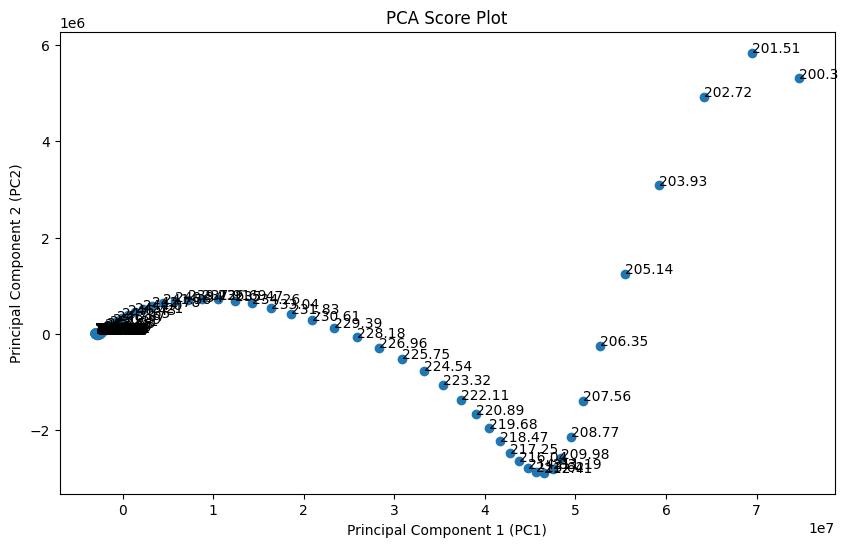

In [47]:
from sklearn.decomposition import PCA

# Extract the feature columns (excluding the 'RT(min)' column)
X = df2
X = X.T
#X = X.iloc[30:]

# Perform PCA
pca = PCA(n_components=2)
scores = pca.fit_transform(X)

# Create a DataFrame for the scores
scores_df = pd.DataFrame(data=scores, columns=['PC1', 'PC2'])

# Score plot
plt.figure(figsize=(10, 6))
plt.scatter(scores_df['PC1'], scores_df['PC2'])

# Add labels and title
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA Score Plot')

# Identify points on the plot using the index of X
for i, sample_name in enumerate(X.index):
    plt.annotate(sample_name, (scores_df['PC1'][i], scores_df['PC2'][i]))

# Show the plot
plt.show()

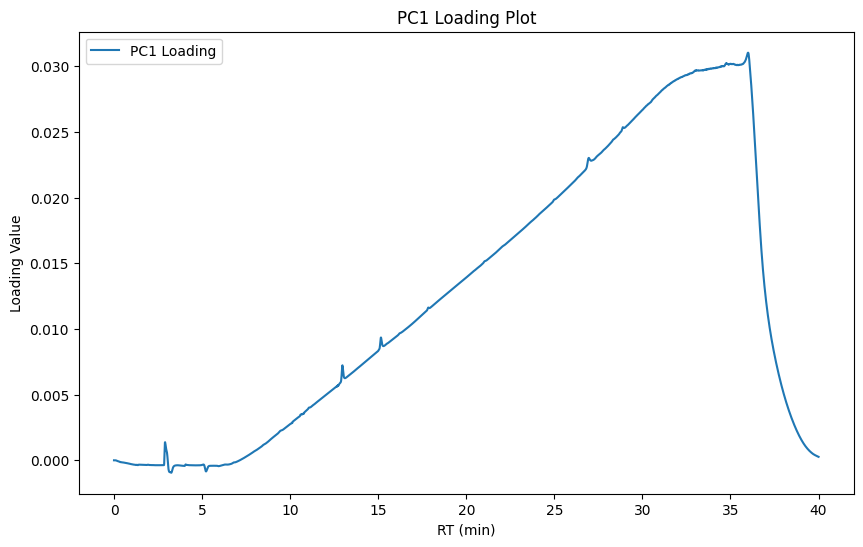

In [48]:
# Loadings Plot

# Access the loadings from the PCA object
loadings = pca.components_

# Plot the loadings for PC1
plt.figure(figsize=(10, 6))
plt.plot(axis['RT(min)'], loadings[0], label='PC1 Loading')
plt.xlabel('RT (min)')
plt.ylabel('Loading Value')
plt.title('PC1 Loading Plot')
plt.legend()
plt.show()

# Plot the loadings for PC2
#plt.figure(figsize=(10, 6))
#plt.plot(combined_df2['RT(min)'], loadings[1], label='PC2 Loading')
#plt.xlabel('RT (min)')
#plt.ylabel('Loading Value')
#plt.title('PC2 Loading Plot')
#plt.legend()
#plt.show()

#### PLS-DA

In [55]:
# Create the Target Vector for the supervision tool (PLS-DA)
df_metadata = pd.read_csv("Metadata.csv", sep=";")
y = df_metadata['target_column']

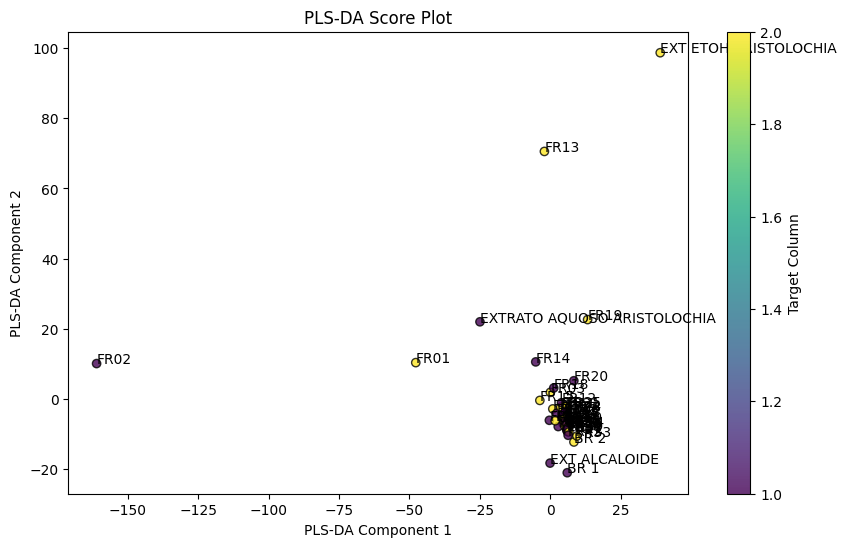

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

# Assuming combined_df2 is your DataFrame
# Replace 'your_data.csv' with your actual file or use your DataFrame directly
# combined_df2 = pd.read_csv('your_data.csv')

# Extract the feature columns (excluding the 'RT(min)' column)
X = combined_df2.iloc[:, 1:]
X = X.T

# Perform PLS-DA
plsr = PLSRegression(n_components=2)
plsr.fit(X, y)
scores = plsr.transform(X)

# Create a DataFrame for the scores
scores_df = pd.DataFrame(data=scores, columns=['PLS-DA Component 1', 'PLS-DA Component 2'])

# Score plot with color-coded points based on 'target_column'
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    scores_df['PLS-DA Component 1'],
    scores_df['PLS-DA Component 2'],
    c=y,
    cmap='viridis',  # Choose a colormap of your preference
    edgecolor='k',  # Add black edges for better visibility
    alpha=0.8  # Adjust the transparency if needed
)

# Add labels and title
plt.xlabel('PLS-DA Component 1')
plt.ylabel('PLS-DA Component 2')
plt.title('PLS-DA Score Plot')

# Identify points on the plot using the index of X
for i, sample_name in enumerate(X.index):
    plt.annotate(sample_name, (scores_df['PLS-DA Component 1'][i], scores_df['PLS-DA Component 2'][i]))

# Add colorbar
cbar = plt.colorbar(scatter, label='Target Column')

# Show the plot
plt.show()


###### Validation - PLS-DA

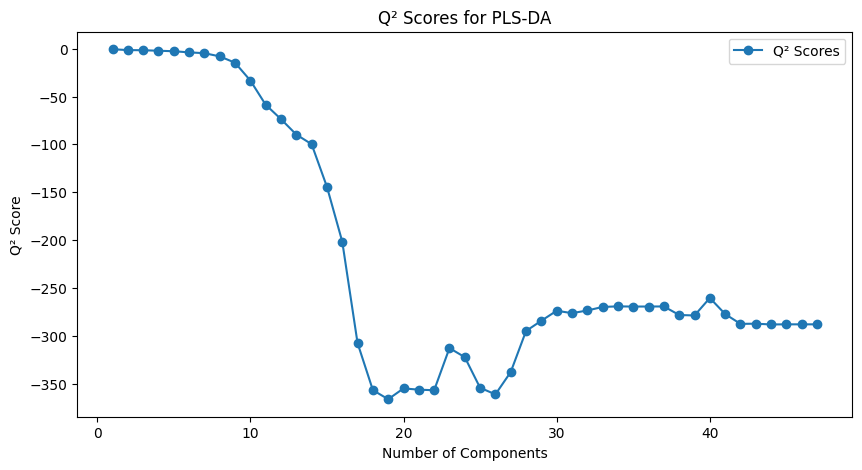

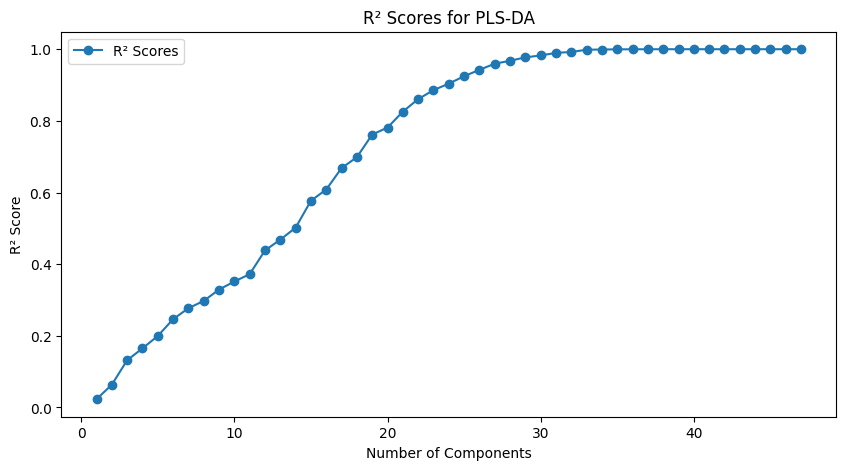

In [74]:
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import r2_score
import warnings

# Disable warnings for the purpose of this demonstration
warnings.filterwarnings("ignore", category=UserWarning)

# Create a GroupKFold object to be used for cross-validation
group_kfold = GroupKFold(n_splits=5)

# Initialize arrays to store Q² and R² scores for each component
num_components = min(X.shape[0], X.shape[1])
q2_scores = np.zeros(num_components)
r2_scores = np.zeros(num_components)

# Perform PLS-DA and evaluate scores for each number of components
for i in range(1, num_components + 1):
    plsr = PLSRegression(n_components=i)
    
    # Cross-validation to get Q² score
    q2_scores[i - 1] = np.mean(cross_val_score(plsr, X, y, cv=group_kfold, groups=X.index))
    
    # Fit the model to get R² score
    plsr.fit(X, y)
    y_pred = plsr.predict(X)
    r2_scores[i - 1] = r2_score(y, y_pred)

# Plot Q² scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_components + 1), q2_scores, marker='o', label='Q² Scores')
plt.xlabel('Number of Components')
plt.ylabel('Q² Score')
plt.title('Q² Scores for PLS-DA')
plt.legend()
plt.show()

# Plot R² scores
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_components + 1), r2_scores, marker='o', label='R² Scores')
plt.xlabel('Number of Components')
plt.ylabel('R² Score')
plt.title('R² Scores for PLS-DA')
plt.legend()
plt.show()

In [71]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score

# Cross-validation to get predicted y values
y_pred = cross_val_predict(plsr, X, y, cv=5)  # You can adjust the number of folds (cv) as needed

# Calculate Q² score
q2 = plsr.score(X, y)
print(f'Q² Score: {q2}')

# Calculate R2 score
r2 = r2_score(y, y_pred)
print(f'R2 Score: {r2}')

print(f"Q2/R2: {q2/r2}.")

Q² Score: 0.06348075500571992
R2 Score: -22.484460449860055
Q2/R2: -0.0028233168034999495.


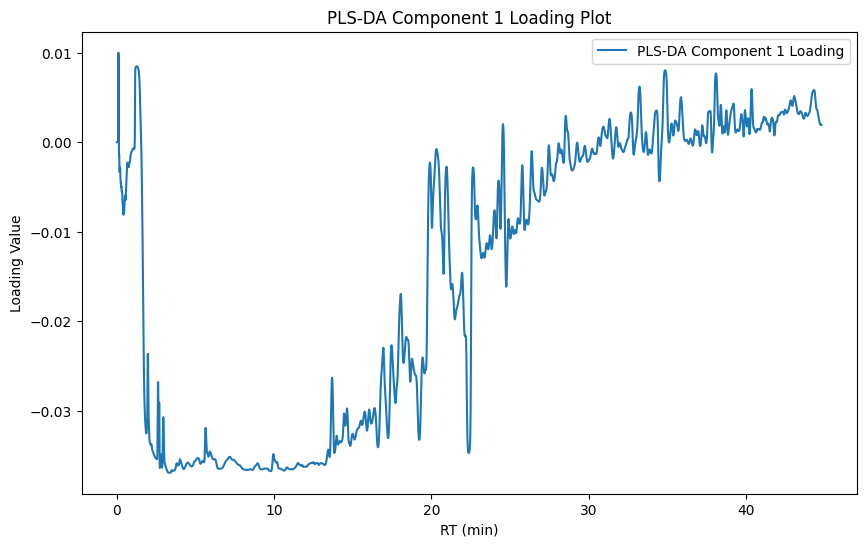

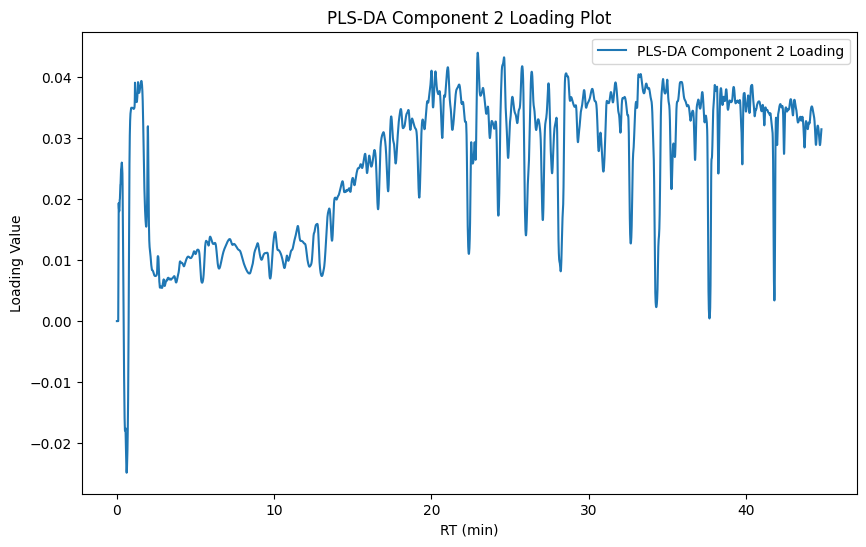

In [61]:
# Loadings PLot
# Access the loadings from the PLSR object
loadings = plsr.x_loadings_

# Plot the loadings for PLS-DA Component 1
plt.figure(figsize=(10, 6))
plt.plot(combined_df2['RT(min)'], loadings[:, 0], label='PLS-DA Component 1 Loading')
plt.xlabel('RT (min)')
plt.ylabel('Loading Value')
plt.title('PLS-DA Component 1 Loading Plot')
plt.legend()
plt.show()

# Plot the loadings for PLS-DA Component 2
plt.figure(figsize=(10, 6))
plt.plot(combined_df2['RT(min)'], loadings[:, 1], label='PLS-DA Component 2 Loading')
plt.xlabel('RT (min)')
plt.ylabel('Loading Value')
plt.title('PLS-DA Component 2 Loading Plot')
plt.legend()
plt.show()


In [76]:
# VIP
from sklearn.cross_decomposition import PLSSVD
from sklearn.preprocessing import StandardScaler

# Standardize the input data
X_standardized = StandardScaler().fit_transform(X)

# Perform PLS-DA using PLSSVD to obtain VIP scores
plssvd = PLSSVD(n_components=1)
plssvd.fit(X_standardized, y)

# Get the VIP scores
vip_scores = plssvd.vip_

# Create a DataFrame for VIP scores
vip_df = pd.DataFrame({'Variable': X.columns, 'VIP Score': vip_scores})

# Sort DataFrame by VIP Score in descending order
vip_df = vip_df.sort_values(by='VIP Score', ascending=False)

# Print or visualize VIP scores
print(vip_df)


AttributeError: 'PLSSVD' object has no attribute 'vip_'